# Direct Transition (Microwave)


## Atomic Circuit


In [1]:
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    ParallelProtocol,  # noqa: F401
    Phonon,
    Pulse,
    SequentialProtocol,  # noqa: F401
    System,
    Transition,
)

downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 12.643e9,
    label="q1",
)
estate = Level(
    principal=6,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 811.29e12,
    label="e0",
)
estate2 = Level(
    principal=6,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=1,
    energy=2 * np.pi * 911.14e12,
    label="e1",
)

transitions = [
    Transition(
        level1=downstate, level2=upstate, einsteinA=1, multipole="M1", label="q0->q1"
    ),
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
    Transition(
        level1=downstate, level2=estate2, einsteinA=1, multipole="E1", label="q0->e1"
    ),
    Transition(
        level1=upstate, level2=estate, einsteinA=1, multipole="E1", label="q1->e0"
    ),
    Transition(
        level1=upstate, level2=estate2, einsteinA=1, multipole="E1", label="q1->e1"
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, -1],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

Yb171_2 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 1],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

COM_x = Phonon(
    energy=2 * np.pi * 1e6, eigenvector=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2), 0, 0]
)

system = System(
    ions=[Yb171, Yb171_2],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[1],
    rabi=2 * np.pi * 3e5,
    detuning=-2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[1],
    rabi=2 * np.pi * 3e5,
    detuning=2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam3 = Beam(
    transition=transitions[1],
    rabi=2 * np.pi * 3e5,
    detuning=-2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)

beam4 = Beam(
    transition=transitions[1],
    rabi=2 * np.pi * 3e5,
    detuning=2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)


protocol = ParallelProtocol(
    sequence=[
        Pulse(beam=beam, duration=1e-3),
        Pulse(beam=beam2, duration=1e-3),
        Pulse(beam=beam3, duration=1e-3),
        Pulse(beam=beam4, duration=1e-3),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [2]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("4_molmer_sorensen.json", "w") as f:
    f.write(circuit_json)

In [3]:
with open("4_molmer_sorensen.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


### Compile


In [4]:
from oqd_compiler_infrastructure import Chain, Post

from oqd_trical.backend import DynamiqsBackend, QutipBackend  # noqa: F401
from oqd_trical.light_matter.compiler.approximate import (
    RotatingReferenceFrame,
    RotatingWaveApprox,
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)

frame_specs = {
    "E0": [0, 2 * np.pi * 12.643e9, 2 * np.pi * 811.29e12, 2 * np.pi * 911.14e12],
    "E1": [0, 2 * np.pi * 12.643e9, 2 * np.pi * 811.29e12, 2 * np.pi * 911.14e12],
    "P0": 2 * np.pi * 1e6,
}

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 1e9)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

In [5]:
from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(hilbert_space), "=" * 80, printer(backend.intermediate), sep="\n")

HilbertSpace
  - hilbert_space: dict
    - E0: set({0, 1, 2, 3})
    - E1: set({0, 1, 2, 3})
    - P0: set({0, 1, 2})
AtomicEmulatorCircuit
  - frame: Operator(79438311838.67151 * |1><1|_E0 @ I_E1 @ I_P0 + 5097485407861727.0 * |2><2|_E0 @ I_E1 @ I_P0 + 5724861460783608.0 * |3><3|_E0 @ I_E1 @ I_P0 + 79438311838.67151 * I_E0 @ |1><1|_E1 @ I_P0 + 5097485407861727.0 * I_E0 @ |2><2|_E1 @ I_P0 + 5724861460783608.0 * I_E0 @ |3><3|_E1 @ I_P0 + 6283185.307179586 * I_E0 @ I_E1 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(942477.796076938 * exp(1j * (6911504.0 * t)) * |2><0|_E0 @ I_E1 @ D(0.06536282797767531 * exp(1j * (6283185.307179586 * t + 1.5707963267948966)))_P0 + 942477.796076938 * exp(1j * (-6911504.0 * t)) * |0><2|_E0 @ I_E1 @ D(0.06536282797767531 * exp(1j * (6283185.307179586 * t + -1.5707963267948966)))_P0 + 942477.796076938 * exp(1j * (-6911504.0 * t)) * |2><0|_E0 @ I_E1 @ D(0.0653628281549217 * exp(1j * (6283185.307179586 * t + 1.570796

### Run


In [6]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-5,
)

10.0%. Run time:  41.31s. Est. time left: 00:00:06:11


20.0%. Run time:  82.03s. Est. time left: 00:00:05:28


30.0%. Run time: 122.66s. Est. time left: 00:00:04:46


40.0%. Run time: 165.80s. Est. time left: 00:00:04:08


50.0%. Run time: 211.18s. Est. time left: 00:00:03:31


60.0%. Run time: 250.65s. Est. time left: 00:00:02:47


70.0%. Run time: 289.84s. Est. time left: 00:00:02:04


80.0%. Run time: 337.53s. Est. time left: 00:00:01:24


90.0%. Run time: 377.36s. Est. time left: 00:00:00:41


100.0%. Run time: 415.70s. Est. time left: 00:00:00:00


Total run time: 415.71s


#### Results


In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

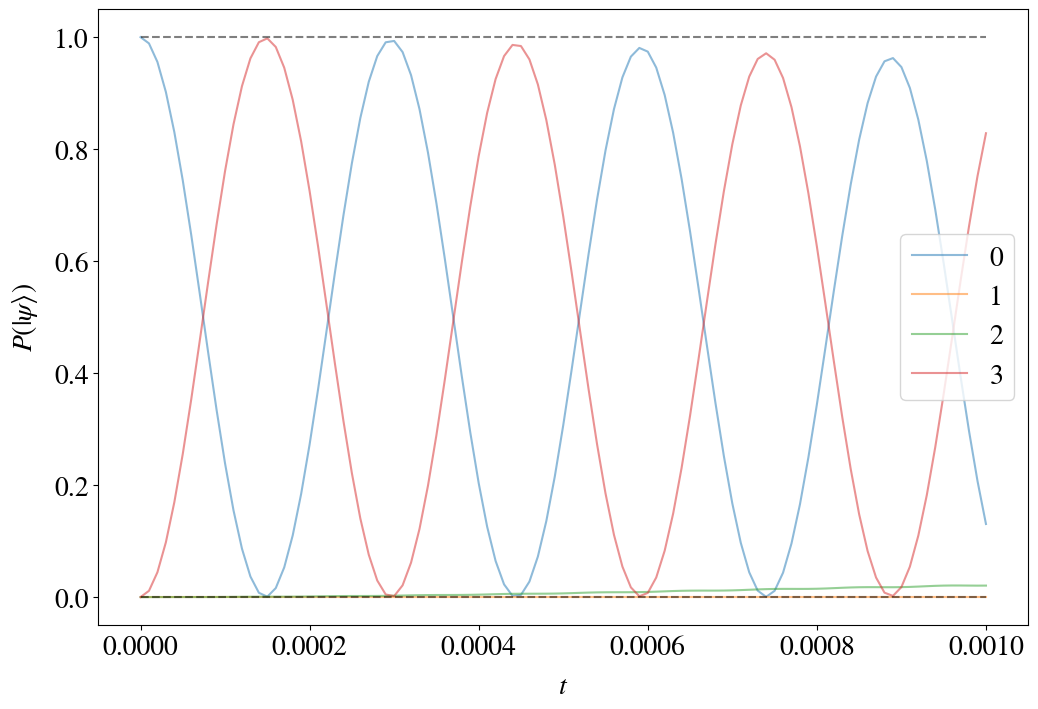

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)


state_labels = [0, 1, 8, 10]
plot_states = [
    [s.ptrace([0, 1]).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(result["tspan"][k], plot_states, label=range(len(state_labels)), alpha=0.5)

ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

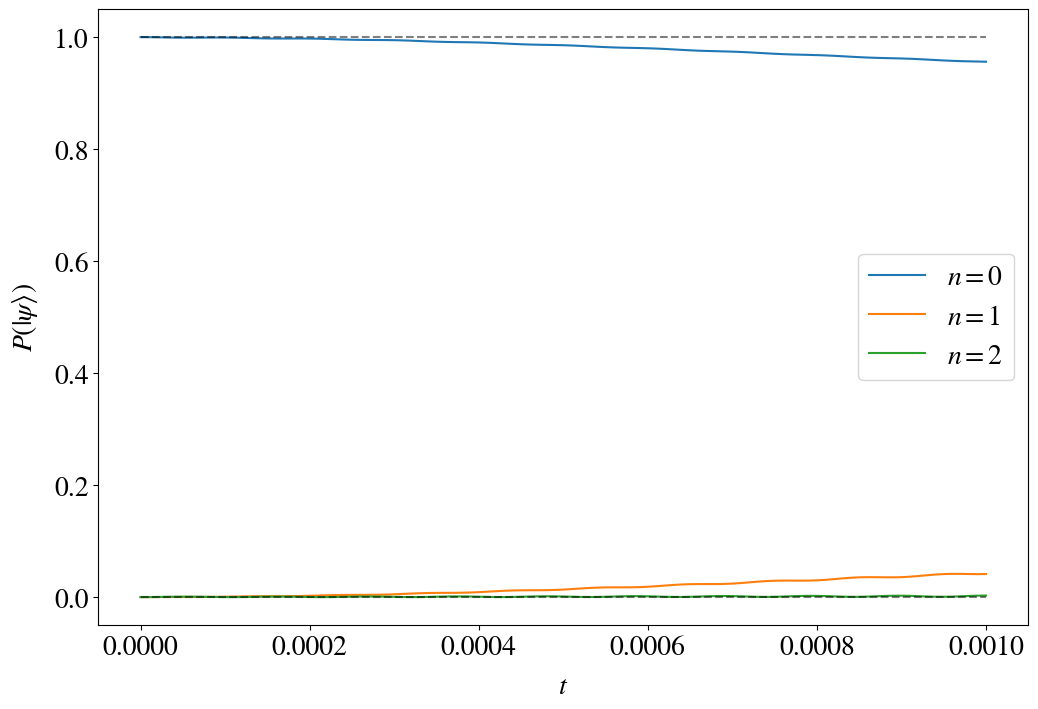

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(2).diag()[:] for s in result["states"][k]],
    label=[rf"$n={n}$" for n in range(fock_cutoff)],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()